In [1]:
from itertools import combinations
from math import sin, cos, sqrt, atan2, radians

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten

from db.mongo import MyMongo

In [2]:
with MyMongo() as db:
    cvs = db.get_df_from_table('cvs', 'cvs')

<--Mongo Connected.
Mongo Connection Closed.-->


In [3]:
idx_lat_empty = cvs['lat'].isna()
cvs.loc[~idx_lat_empty].head(1)

,_id,lat,lng,개방서비스ID,개방서비스명,개방자치단체코드,관리번호,데이터갱신구분,데이터갱신일자,도로명우편번호,...,인허가일자,인허가취소일자,재개업일자,좌표정보(X),좌표정보(Y),지정일자,최종수정시점,폐업일자,휴업시작일자,휴업종료일자
0,5c08bec59085ca65eac3dbc9,37.5755739237728,126.985645756747,11_43_02_P,담배소매업,3000000.0,2006300010105600037,I,2018-08-31 23:59:59.0,NaN,...,20060921,NaN,NaN,198658.943470079,452604.254902527,NaN,20080221000000.0,NaN,NaN,NaN


In [4]:
print(cvs.columns)
len(cvs.loc[~idx_lat_empty])

Index(['_id', 'lat', 'lng', '개방서비스ID', '개방서비스명', '개방자치단체코드', '관리번호', '데이터갱신구분',
       '데이터갱신일자', '도로명우편번호', '도로명전체주소', '민원종류명', '번호', '사업장명', '상세영업상태명',
       '상세영업상태코드', '소재지면적', '소재지우편번호', '소재지전체주소', '소재지전화', '업태구분명', '영업상태구분코드',
       '영업상태명', '인허가일자', '인허가취소일자', '재개업일자', '좌표정보(X)', '좌표정보(Y)', '지정일자',
       '최종수정시점', '폐업일자', '휴업시작일자', '휴업종료일자'],
      dtype='object')


33159

In [5]:
pd.set_option('display.max_columns', None)
cols = ['lat', 'lng', '관리번호', '사업장명', '상세영업상태명', '도로명전체주소']
cvs.loc[~idx_lat_empty, cols].head(1)

cvs['도로명전체주소'] = cvs['도로명전체주소'].fillna('')

idx_blank = cvs['도로명전체주소']==''
idx_seoul = cvs['도로명전체주소'].str.contains('서울')
idx_busan = cvs['도로명전체주소'].str.contains('부산')
idx_daegu = cvs['도로명전체주소'].str.contains('대구')
idx_incheon = cvs['도로명전체주소'].str.contains('인천')
idx_ulsan = cvs['도로명전체주소'].str.contains('울산')
idx_gwangju = cvs['도로명전체주소'].str.contains('광주')
idx_daejeon = cvs['도로명전체주소'].str.contains('대전')
idx_jeju = cvs['도로명전체주소'].str.contains('제주')
idx_sejong = cvs['도로명전체주소'].str.contains('세종')
idx_kyungki = cvs['도로명전체주소'].str.contains('경기')
idx_gangwon = cvs['도로명전체주소'].str.contains('강원')
idx_cb = cvs['도로명전체주소'].str.contains('충청북도') | cvs['도로명전체주소'].str.contains('충북')
idx_cn = cvs['도로명전체주소'].str.contains('충청남도') | cvs['도로명전체주소'].str.contains('충남')
idx_jb = cvs['도로명전체주소'].str.contains('전라북도') | cvs['도로명전체주소'].str.contains('전북')
idx_jn = cvs['도로명전체주소'].str.contains('전라남도') | cvs['도로명전체주소'].str.contains('전남')
idx_kb = cvs['도로명전체주소'].str.contains('경상북도') | cvs['도로명전체주소'].str.contains('경북')
idx_kn = cvs['도로명전체주소'].str.contains('경상남도') | cvs['도로명전체주소'].str.contains('경남')

idx_all = idx_blank| idx_seoul| idx_busan| idx_daegu| idx_incheon| idx_ulsan| idx_gwangju| idx_daejeon| idx_jeju| idx_sejong| idx_kyungki|\
            idx_gangwon| idx_cb| idx_cn| idx_jb| idx_jn| idx_kb| idx_kn

idx_regions = [idx_seoul, idx_busan, idx_daegu, idx_incheon, idx_ulsan, idx_gwangju, idx_daejeon, idx_jeju, idx_sejong, idx_kyungki,
               idx_gangwon, idx_cb, idx_cn, idx_jb, idx_jn, idx_kb, idx_kn,]
idx_regions = [idx_blank |idx  for idx in idx_regions]

# idx_ = cvs['도로명전체주소'].str.contains('')
# idx_ = cvs['도로명전체주소'].str.contains('')
# idx_ = cvs['도로명전체주소'].str.contains('')






In [6]:
print(len(cvs))
print(len(cvs.loc[idx_all, cols]))
print(len(cvs.loc[idx_seoul, cols]))

cvs.loc[~idx_all, cols].head(3)

# len(cvs.loc[cvs['도로명전체주소'].isna()])

65541
65541
12978


,lat,lng,관리번호,사업장명,상세영업상태명,도로명전체주소


In [7]:
print(len(cvs.loc[idx_jeju]))

1562


# kmeans

3307


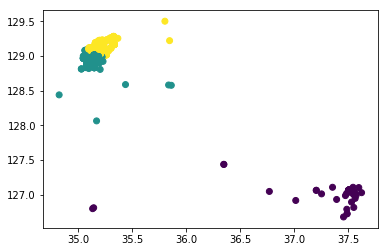

In [8]:


coordinates = np.array(cvs.loc[~idx_lat_empty & idx_busan, ['lat', 'lng']].astype(float))
print(len(coordinates))
# print(whiten(coordinates))

x, y = kmeans2(whiten(coordinates), 3, iter = 20)
plt.scatter(coordinates[:,0], coordinates[:,1], c=y);
plt.show()

In [9]:
y

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

# geohash

In [76]:
import pygeohash as pgh
from collections import defaultdict

geos = np.array(cvs.loc[~idx_lat_empty & idx_seoul, ['관리번호', 'lat', 'lng']])
# len(geos)
geo_hash_list = [(pgh.encode(float(g[1]), float(g[2])), g[0]) for g in geos]

geo_hash_table = defaultdict(list)

for g in geo_hash_list:
    geo_hash_table[g[0]].append(g[1])

i = 0
for k, v in geo_hash_table.items():
    if i == 3:
        break
    i += 1
    print(k, v)
    
# print(geo_hash_list[0])
# print(geo_hash_table[:3])

# pgh.geohash_approximate_distance(hashes[0], hashes[1])
# pgh.geohash_haversine_distance(hashes[4], hashes[1])
# 118, 19

wydmc8kjs48m ['2006300010105600037', '2006300007605600015']
wydmf1bkwpb0 ['1999300007605600150']
wydmc24fs0m9 ['2007300010105600043']


In [86]:
geos[:3]
id_geo = {}
for g in geos:
    id_geo[g[0]] = (float(g[1]), float(g[2]))

In [77]:
tmp = pd.DataFrame(columns=['geohash', '관리번호'], data=geo_hash_list); tmp.head(2)

,geohash,관리번호
0,wydmc8kjs48m,2006300010105600037
1,wydmf1bkwpb0,1999300007605600150


In [58]:
tmp.groupby('geohash').count()

,관리번호
geohash,
wy4pu79262r5,1
wy4r8w8zsk1v,1
wy4wpzcs8jes,1
wy5rzz1w194f,1
wy60nq051fvx,2
wy60rdtwy2j4,1
wy6tmjc66kwc,1
wy6wehnp5f79,1
wy72jxs28ywm,1


In [37]:
hashes = [g[0] for g in geo_hash_list]
comb_hash = combinations(hashes, 2)
comb_hash

# for idx_region in idx_regions:
#     ids = cvs.loc[~idx_lat_empty & idx_region]['관리번호'].tolist()
#     print(len(ids))
#     comb_list.append(combinations(ids, 2))

# print(comb_list)

In [38]:
result_hash = []

for c in comb_hash:
    d = pgh.geohash_approximate_distance(c[0], c[1])
    if d < 200:
        result_hash.append(c)


In [69]:
src_dst = pd.DataFrame(columns=['src', 'dst'], data=result_hash)
print(len(src_dst))
src_dst.drop(src_dst[(src_dst['src']==src_dst['dst'])].index, inplace=True)
print(len(src_dst))
src_dst.drop_duplicates(inplace=True)
print(len(src_dst))
src_dst.head(1)

16719
7481
3764


,src,dst
1,wydmf1bkwpb0,wydmf1b673r1


In [80]:
result_ids = []
i = 0
for idx, row in src_dst.iterrows():
#     if i == 3:
#         break
#     i += 1
    src = row['src']
    dst = row['dst']
    srces = geo_hash_table[src]
    dsts = geo_hash_table[dst]
    
    
    for s in srces:
        for d in dsts:
            result_ids.append((s, d))

In [83]:
print(len(result_ids))
print(result_ids[:3])

10779
[('1999300007605600150', '2015300016905600093'), ('2007300010105600043', '2015300016905600098'), ('2007300010105600043', '2004300007605600079')]


In [96]:

for r in result_ids[:10]:
    src = id_geo[r[0]]
    dst = id_geo[r[1]]
    lat1, lon1, lat2, lon2 = src[0], src[1], dst[0], dst[1]
    d = get_distance_from_coords(lat1, lon1, lat2, lon2)
    print(r[0], r[1], d)
#     print(src, dst)

1999300007605600150 2015300016905600093 47.76831894842475
2007300010105600043 2015300016905600098 60.58857147435068
2007300010105600043 2004300007605600079 60.58857147435068
2007300010105600043 2013300012905600007 42.56555056674884
2008300012905600082 2013300012905600009 90.5192139250219
2008300012905600082 2010300012905600088 90.5192139250219
2008300012905600082 2012300012905600083 90.5192139250219
2007300012905600055 2017300016905600061 64.319824212411
2008300012905600071 1999300007605600125 80.58657010516268
2008300012905600071 2017300016905600078 80.58657010516268


In [97]:
# 2013300012905600009 2010300012905600088
tmp_list = ['2008300012905600082', '2013300012905600009', '2010300012905600088']
cvs.loc[(cvs['관리번호'].isin(tmp_list)), cols]

,lat,lng,관리번호,사업장명,상세영업상태명,도로명전체주소
4,37.577146200573374,126.96943017884111,2008300012905600082,세븐일레븐 종로배화점,정상영업,서울특별시 종로구 필운대로 12 (필운동)
224,37.576335287688764,126.96933996356815,2013300012905600009,씨유 종로사직공원점,정상영업,"서울특별시 종로구 사직로 95, 제1층 -1호 (필운동)"
289,37.576335287688764,126.96933996356815,2010300012905600088,씨유 종로누상점,폐업처리,서울특별시 종로구 옥인길 23-1 (누상동)


In [51]:
result_distance = []
# len(result_hash)
for r in result_hash:
    real_d = pgh.geohash_haversine_distance(r[0], r[1])
    result_distance.append((r[0], r[1], real_d))

In [61]:
result_distance[:10]
# len(result_distance)

[('wydmc8kjs48m', 'wydmc8kjs48m', 0.0),
 ('wydmf1bkwpb0', 'wydmf1b673r1', 47.78824862591178),
 ('wydmc24fs0m9', 'wydmc242x7cc', 60.60183233297039),
 ('wydmc24fs0m9', 'wydmc24b78zz', 42.620562750545325),
 ('wydmc24fs0m9', 'wydmc242x7cc', 60.60183233297039),
 ('wydmc28qdpv0', 'wydmc286009g', 90.5271991930163),
 ('wydmc28qdpv0', 'wydmc286009g', 90.5271991930163),
 ('wydmc28qdpv0', 'wydmc286009g', 90.5271991930163),
 ('wydmcfqsy46k', 'wydmcfqsy46k', 0.0),
 ('wydmcqtx4vq3', 'wydmcqtjex94', 64.36317571705051)]

# bruteforce

In [95]:
def get_distance_from_coords(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6371.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c * 1000
    return distance

In [12]:
# comb_list = []
# for idx_region in idx_regions:
#     ids = cvs.loc[~idx_lat_empty & idx_region]['관리번호'].tolist()
#     print(len(ids))
#     comb_list.append(combinations(ids, 2))

# print(comb_list)

In [13]:
# result = []
# # i = 0
# cvs_region = cvs.loc[idx_regions[-1]]
# for c in tqdm_notebook(comb_list[-1]):
# #     if i == 3:
# #         break
# #     i += 1
   
#     id1 = c[0]
#     id2 = c[1]

#     cvs1 = cvs_region.loc[cvs_region['관리번호']==id1]
#     cvs2 = cvs_region.loc[cvs_region['관리번호']==id2]
    
#     lat1 = cvs1['lat']
#     lon1 = cvs1['lng']
#     lat2 = cvs2['lat']
#     lon2 = cvs2['lng']
    
#     distance = get_distance_from_coords(lat1, lon1, lat2, lon2)
#     if distance <= 1000:
#         result.append((id1, id2, distance))
    
# #     if len(result) > 5:
# #         break

# #     print(cvs0.loc[::, cols])
# #     print(cvs1.loc[::, cols])
# print(len(result))